In [83]:
import json
import collections
import itertools
import copy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
from scipy import stats
from scipy.misc import derivative

In [110]:
def unique_justseen(iterable, key=None):
    """List unique elements, preserving order. Remember only the element just seen."""
    # unique_justseen('AAAABBBCCDAABBB') --> A B C D A B
    # unique_justseen('ABBCcAD', str.lower) --> A B C A D
    return list(map(next, map(lambda x: x[1], itertools.groupby(iterable, key))))


def get_bins(iterable, nbins=1, key=lambda x: x, ceil_bin=False, full=False):
    vals = [key(x) for x in iterable]
    min_v = min(vals)
    max_v = max(vals)
    bin_size = ((1 + max_v - min_v) / float(nbins))
    bin_size = math.ceil(bin_size) if ceil_bin else bin_size
    bins = [[] for _ in range(nbins)]
    for c in iterable:
        cv = key(c)
        cbin = int((cv - min_v) / bin_size)
        bins[cbin].append(c)
    return bins if not full else (bins, bin_size, min_v, max_v, len(vals))

def get_distib_fbins(iterable, bin_tup, non_zero=True):  # bins = bins, size, minv, maxv
    bins, size, minv, maxv, ln = bin_tup
    return [x for x in [(minv + (idx+0.5)*size, len(bins[idx])/float(ln)) for idx in range(len(bins))] if not non_zero or x[1] > 0]    

def get_distrib(iterable, nbins=100, key=lambda x: x, non_zero=True):
    inp = list(iterable)
    return get_distib_fbins(iterable, get_bins(inp, nbins=nbins, key=key, full=True), non_zero=non_zero)

def binize(x, bin_tup):  # returns bin idx where the x lies, None if out of region
    bins, size, minv, maxv, ln = bin_tup
    if x < minv or x > maxv+size:
        return None
    return int((x - minv) // size)

def binned_pmf(x, bin_tup):
    idx = binize(x, bin_tup)
    if idx is None:
        return 0
    return len(bin_tup[0][idx])/float(bin_tup[4])

def is_crossed(pt, bound, direction):
    return (bound >= pt) if direction > 0 else (bound <= pt)
    
def move_bound(bnd, dx, direction):
    return bnd + dx if direction > 0 else bnd - dx
    
def all_diffs(vals):
    diffs, ln = [], len(vals)
    for i in range(ln):
        for j in range(i, ln):
            diffs.append(vals[i] - vals[j])
    return diffs
    
def pvalue_comp(fnc, extremes, dx):
    """Extremes = [(val, direction +1\-1)] """
    nints = len(extremes)
    areas = [0] * nints
    nbounds = [x[0] for x in extremes]
    bmin = min(nbounds)
    bmax = max(nbounds)
    cp = 0
    iterc = 0
    results = []
    
    while cp <= 1.0:  # integration step
        iterc += 1
        if iterc > 10000:
            raise ValueError('exc')
        # Termination condition = some bound reached.
        # Due to discrete nature (num. integration, disc CDF) we check for the 
        # bound overlap with the previous step. For that the direction is needed.
        #crossed = False
        #for ix in range(nints):
        #    crossed |= is_crossed(cur, nbounds[ix], extremes[ix][1])
        #if crossed:
        #    break
        
        # Integration by increasing pvalue and tabulating.
        # Each area grows at the same pace. pvalue is a sum of areas.
        # Termination - bounds are crossing / touching.
        
        # Integrate each area with one step but in such a way the area is the same. 
        max_area = max(areas)
        min_area = min(areas)
        sum_area = sum(areas)
        err = max([abs(x) for x in all_diffs(areas)])
        areas_str = ['%.7f' % x for x in areas]
        print('Main iter: %s, cp: %.7f, mina: %.7f, maxa: %.7f, suma: %.7f, err: %.7f, a: [%s]' 
              % (iterc, cp, min_area, max_area, sum_area, err, ', '.join(areas_str)))
        
        subit = 0
        while any([x <= min_area for x in areas]):
            subit += 1
            print('.. subit: %s' % subit)
            
            for ix in range(nints):
                if areas[ix] > min_area :
                    continue
                    
                areas[ix] += fnc(nbounds[ix])
                nbounds[ix] = move_bound(nbounds[ix], dx, extremes[ix][1])        
            #err = max([abs(x) for x in all_diffs(areas)])
            #if err > dx*dx:
            #    min_area = min(areas)
        cp = sum(areas)
        
        crit_int = [None]*nints
        for i in range(nints):
            crit_int[i] = (extremes[i][0], nbounds[i]) if extremes[i][1] > 0 else (nbounds[i], extremes[i][0])
        results.append((cp, crit_int))
        
    print('Main iter: %s, cp: %s, mina: %s, maxa: %s, suma: %s, a: %s' 
              % (iterc, cp, min(areas), max(areas), sum(areas), areas))
    print(json.dumps(results, indent=2))
    return results

In [52]:
js = json.load(open('ref_1554219251.json'))
csv = open('ref_1554219251.csv').read()

In [5]:
csv_data = []
for rec in [x.strip() for x in csv.split("\n")]:
    p = rec.split(';')
    if len(p) < 6:
        continue
    cur = collections.OrderedDict([
        ('method', p[0]), 
        ('block', int(p[1])),
        ('deg', int(p[2])),
        ('comb_deg', int(p[3])),
        ('data_size', int(p[4])),
        ('zscores', [float(x.replace(',','.')) for x in p[6:]])
    ])
    csv_data.append(cur)
print(json.dumps(csv_data[0]))    

{"method": "in0-kctr-ri1", "block": 128, "deg": 1, "comb_deg": 2, "data_size": 10, "zscores": [-3.77991]}


In [6]:
data = csv_data

In [7]:
data_filt = [x for x in data if x and len(x['zscores']) > 1000]
data_filt.sort(key=lambda x: (x['method'], x['block'], x['deg'], x['comb_deg'], x['data_size']))

<class 'scipy.stats._distn_infrastructure.rv_discrete'>
[0.00020231 0.00010115 0.00192191] wwwwww
[0. 0. 0.]
[0.00020231 0.00010115 0.00192191]
Main iter: 1, cp: 0.0000000, mina: 0.0000000, maxa: 0.0000000, suma: 0.0000000, err: 0.0000000, a: [0.0000000, 0.0000000, 0.0000000, 0.0000000]
.. subit: 1
.. subit: 2
.. subit: 3
.. subit: 4
.. subit: 5
.. subit: 6
.. subit: 7
.. subit: 8
.. subit: 9
.. subit: 10
.. subit: 11
.. subit: 12
.. subit: 13
.. subit: 14
.. subit: 15
.. subit: 16
.. subit: 17
.. subit: 18
.. subit: 19
Main iter: 2, cp: 0.0010115, mina: 0.0002023, maxa: 0.0003035, suma: 0.0010115, err: 0.0001012, a: [0.0002023, 0.0003035, 0.0003035, 0.0002023]
.. subit: 1
Main iter: 3, cp: 0.0013150, mina: 0.0003035, maxa: 0.0004046, suma: 0.0013150, err: 0.0001012, a: [0.0004046, 0.0003035, 0.0003035, 0.0003035]
.. subit: 1
Main iter: 4, cp: 0.0022254, mina: 0.0004046, maxa: 0.0008092, suma: 0.0022254, err: 0.0004046, a: [0.0004046, 0.0004046, 0.0006069, 0.0008092]
.. subit: 1
.. sub

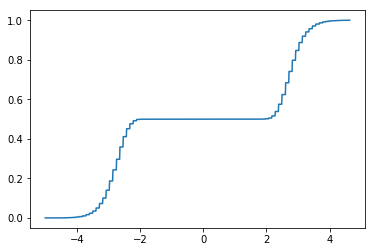

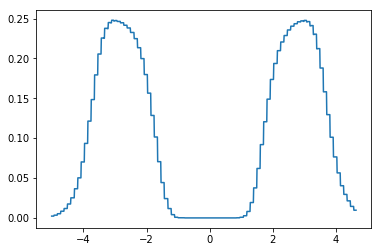

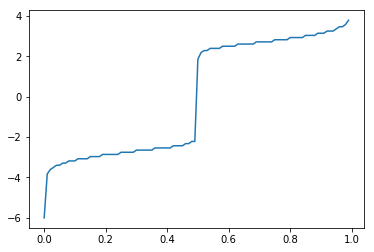

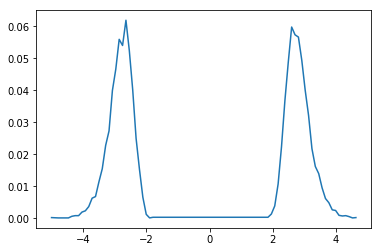

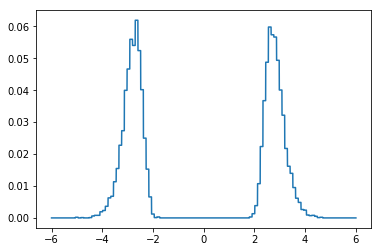

In [111]:
#print(data_filt[0])
np.random.seed(87655677)
crit01, crit05, crit10 = stats.t.ppf([1-0.01, 1-0.05, 1-0.10], 10)

for ix, val in enumerate(data_filt):
    inp_iter = (val['zscores'])
    nbins = 100
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    bins = np.array([x[0] for x in bb])
    dst = stats.rv_discrete(values=([x[0] for x in bb if x[1] > 0],[x[1] for x in bb if x[1] > 0]))
    print(stats.rv_discrete)
    
    x=np.array([bins[0], bins[1], bins[6]])
    print(np.select([x == k for k in dst.xk],
                         [np.broadcast_arrays(p, x)[0] for p in dst.pk], 0), 'wwwwww')
    print(dst.pmf(x))
    print(dst._pmf(x))
    
    # Tabulate pvalues
    pvalue_comp(lambda x: binned_pmf(x, bin_tup), [
        [bin_tup[2], 1],
        [0, -1],
        [0, +1],
        [bin_tup[3], -1]
    ], dx=1./(nbins/10.))
    
    n_sample = 100
    rvs = dst.rvs(size=n_sample)
    f, l = np.histogram(rvs, bins=bins)
    f = np.append(f, [0])
    probs = np.array([x[1] for x in bb])
    #print(bins, len(bins))
    #print(probs, len(probs))
    #print(f, len(f))
    sfreq = np.vstack([np.array([x[0] for x in bb]), f, probs*n_sample]).T
    #print(sfreq)
    
    print(dst.ppf(np.linspace(0,1,10)))
    print(dst.pmf(4.63699389))
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    x = np.linspace(min(bins),max(bins),1000)
    plt.plot(x,dst.cdf(x))
    plt.show()
    
    cdf_dev = derivative(dst.cdf, x, dx=1)
    plt.plot(x,cdf_dev)
    plt.show()
    
    x = np.linspace(0,100,10000)
    plt.plot(x,dst.ppf(x))
    plt.show()
    
    x = np.linspace(-10,10,10000)
    plt.plot(bins, dst._pmf(bins))
    plt.show()
    
    x = np.linspace(-6,6,10000)
    plt.plot(x, [binned_pmf(y, bin_tup) for y in x])
    plt.show()
    
    # Idea: pvalue function = pms of the distribution. 
    # If test returns z-score with p=0 then we reject the hypothesis as we didnt get such zscore
    # If test returns with p=0.3 we dont reject as we have our alpha set somehow...
    # Problem: number of bins. If too many, we have small probabilities -> some alphas not reachable.
    
    break
    

In [22]:
np.arange(7)
#np.zeros(np.shape(0.5),'d')
#print(dst.ppf([1-0.01, 1-0.05, 1-0.10, 0.5, 0.6]))

array([0, 1, 2, 3, 4, 5, 6])

In [41]:
# Compute pvalues
def compute_pvals(dset):
    zs = sorted()
    pass

9886


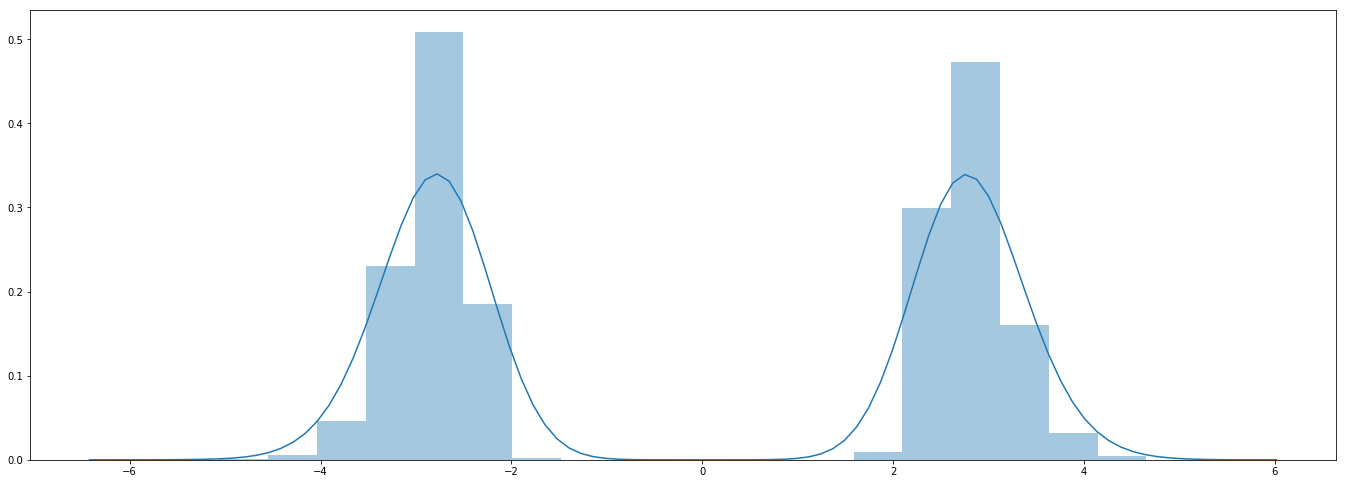

In [93]:
a4_dims = (2*11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
zs = data_filt[1]['zscores']

for  i in range(1):
    zs = [x for x in data_filt[i]['zscores']]
    print(len(zs))
    sns.distplot(a=zs, ax=ax, hist=True, norm_hist=False, bins='auto')

# pvalues
 - pvalue = probability (in the null hypothesis distribution) to be observed as a value equal to or more extreme than the value observed
 
## computation 
 - Derive CDF -> find 0 regions = extremes
 - Integrate from 0 regions towards region of increasing integral value. 
 - Once sum of all integrations is alpha, stop. Integrated area is a critical region
 - Computation for x: integrate until the first integral boundary hits x. pvalue = sum of integrals
 - Tabulation: for each desired pvalue compute boundaries (4 values) where critical region starts. 
 - pvalue(x): need to do the integration OR function table (\forall zscores: P(zscore) > 0).
 - In our case 4 extremes, integrate: 
   - -\inf towards 0
   - +\inf towards 0
   - 0 towards +\inf
   - 0 towards -\inf
   